# PyGlaucoMetrics: An open-source Python repository that standardizes and assesses Visual Field (VF) data. Our repository automatically identifies signs of glaucoma based on predefined criteria.

# General overview:
# 1- Import raw VF data
df_VFs = pd.read_csv('VF_Data.csv')

# 2- Get td, tdp, pd, and pdp from PyVisualField Package.
df_td, df_tdp, df_pdp = visualFields.getallvalues(df_VFs)

# 3- Obtain required columns from each dataframe
raw_data_pdp = df_pdp.loc[:, 'l1':'l54'] raw_data_td = df_td.loc[:, 'l1':'l54'] raw_data_tdp = df_tdp.loc[:, 'l1':'l54']

# 4- Call each function and save resulted diagnosis
df_diag_HAP2 = Fn_HAP2_part2(raw_data_pdp) # it needs pdp values. will compute if necessary df_diag_UKG = Fn_UKGTS(raw_data_td) #it needs tdp values, will compute if necessary df_diag_logts = Fn_LoGTS(raw_data_tdp) # it need TD values, will compute if necessary

In [6]:
# Import Libraries
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from PyVisualFields import visualFields
from PyVisualFields import vfprogression
import warnings

warnings.filterwarnings("ignore", category=FutureWarning, module="rpy2.robjects.pandas2ri")


In [7]:
# Read original and restructured data
org_data = pd.read_csv('D:/PyVisualField/VF_Data_org.csv', encoding='windows-1254')
#m1 = pd.read_csv('D:/PyVisualField/VF_Data_restructured.csv', encoding='windows-1254')
org_data

,id,gender,eye,fieldN,age,time_from_Baseline,MS,MS_Cluster1,MS_Cluster2,MS_Cluster3,...,PD_45,PD_46,PD_47,PD_48,PD_49,PD_50,PD_51,PD_52,PD_53,PD_54
0,647,F,Right,1,52.7967,0.0000,27.832885,25.57750,26.979231,30.588333,...,-1.92,-0.36,-0.44,-1.52,-0.03,-1.06,0.75,-1.33,-2.02,-0.61
1,647,F,Right,2,53.8234,1.0267,30.131346,27.76000,29.911538,33.263333,...,-0.54,-1.13,-1.81,-1.74,-2.19,-1.23,-4.85,-2.24,0.00,0.28
2,647,F,Right,3,54.8857,2.0890,29.454808,25.47500,29.826154,32.488333,...,-0.07,1.56,-2.09,0.07,-0.84,-2.45,-0.48,-4.10,-1.28,-4.07
3,647,F,Right,4,57.7331,4.9363,27.947885,23.75625,28.658462,31.431667,...,-2.57,-1.74,-0.52,-2.70,-1.48,-3.32,-3.00,-6.49,-2.19,-2.76
4,647,F,Right,5,58.7680,5.9713,27.644038,24.90250,28.104615,30.105000,...,-0.80,-0.93,-3.08,-2.55,-3.26,-3.13,-1.42,-0.18,-1.02,-2.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28938,7324,F,Left,2,65.6537,0.2163,27.471923,25.32125,25.657692,30.785000,...,0.30,-3.89,-4.68,-3.45,-0.88,-0.72,0.00,-2.81,-0.83,-2.02
28939,6859,M,Right,1,79.4114,0.0000,23.916346,26.37000,15.611538,15.225000,...,-0.43,-0.71,-3.52,0.00,-0.60,1.05,-3.96,-2.23,0.25,-2.06
28940,6859,M,Right,2,80.6598,1.2485,23.475192,23.74500,13.599231,22.355000,...,0.00,-0.85,-0.70,0.20,-0.16,-1.95,1.20,-3.11,-1.91,-0.93
28941,1142,NaN,Left,1,67.3155,0.0000,27.896923,26.95250,29.080000,30.493333,...,-4.77,-4.94,-9.38,-6.18,-2.88,-2.18,-2.61,-3.51,-2.83,-0.09


In [8]:
pd.options.mode.chained_assignment = None  # Suppresses the SettingWithCopyWarning

# Check the required columns in the data structure
required_columns = ['id', 'eye', 'date', 'time', 'age', 'type', 'fpr', 'fnr', 'fl', 'duration']

# Check if all required columns exist in the DataFrame
missing_columns = [col for col in required_columns if col not in org_data.columns]

# If any required columns are missing, add them and assign NaN to each row
if missing_columns:
    for col in reversed(required_columns):
        if col in missing_columns:
            org_data.insert(0, col, float('nan'))

# Create a new DataFrame with only the required columns in the specified order
restruc_data = org_data[required_columns + [col for col in org_data.columns if col not in required_columns]]

# Replace NaN values with 0 except for string type columns
# Define columns to exclude from filling NaNs
exclude_columns = ['gender', 'eye', 'type']

# Iterate over columns and fill NaNs with 0, excluding specified columns
for column in restruc_data.columns:
    if column not in exclude_columns:
        restruc_data.loc[:, column] = restruc_data[column].fillna(0)

# Select required columns and l1 to l54
required_columns.extend([f'l{i}' for i in range(1, 55)])
df_input = restruc_data[required_columns]
# Replace 'Right' with 'OD' and 'Left' with 'OS' in the 'eye' column
df_input['eye'].replace({'Right': 'OD', 'Left': 'OS'}, inplace=True)

# Ensure correct data types
df_input['id'] = df_input['id'].astype('int32')
df_input['age'] = df_input['age'].astype('int32')
df_input['date'] = pd.to_datetime(df_input['date'])
#df_input['time'] = df_input['time'].astype('object')  # Assuming time format is not standardized
#df_input[['fpr', 'fnr', 'fl', 'duration']] = df_input[['fpr', 'fnr', 'fl', 'duration']].astype('float64')
df_input[[f'l{i}' for i in range(1, 55)]] = df_input[[f'l{i}' for i in range(1, 55)]].astype('int32')


print(df_input)
print(df_input.dtypes)

         id eye       date  time  age  type  fpr  fnr   fl  duration  ...  \
0       647  OD 1970-01-01   0.0   52   NaN  0.0  0.0  0.0       0.0  ...   
1       647  OD 1970-01-01   0.0   53   NaN  0.0  0.0  0.0       0.0  ...   
2       647  OD 1970-01-01   0.0   54   NaN  0.0  0.0  0.0       0.0  ...   
3       647  OD 1970-01-01   0.0   57   NaN  0.0  0.0  0.0       0.0  ...   
4       647  OD 1970-01-01   0.0   58   NaN  0.0  0.0  0.0       0.0  ...   
...     ...  ..        ...   ...  ...   ...  ...  ...  ...       ...  ...   
28938  7324  OS 1970-01-01   0.0   65   NaN  0.0  0.0  0.0       0.0  ...   
28939  6859  OD 1970-01-01   0.0   79   NaN  0.0  0.0  0.0       0.0  ...   
28940  6859  OD 1970-01-01   0.0   80   NaN  0.0  0.0  0.0       0.0  ...   
28941  1142  OS 1970-01-01   0.0   67   NaN  0.0  0.0  0.0       0.0  ...   
28942  1142  OS 1970-01-01   0.0   67   NaN  0.0  0.0  0.0       0.0  ...   

       l45  l46  l47  l48  l49  l50  l51  l52  l53  l54  
0       26   29  

# Obtaining TDP and PDP using PyVisualField Package. Please install approperiate packages/libraries as described at: (https://github.com/mohaEs/PyVisualField/blob/main/readme_Installation.md)


Shape of Total Deviation:(54,)
Type of Total Deviation: <class 'tuple'>


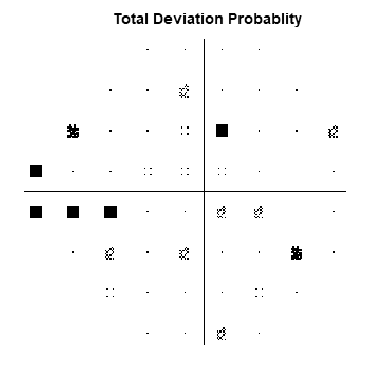

In [9]:
# Obtaining TDP and PDP using PyVisualField Package 

df_td, df_tdp, df_gi, df_gip, df_pd, df_pdp, gh = visualFields.getallvalues(df_input)#df_VFs_py data is acquired using 24-2 Vfs

ind_td_start=df_td.columns.get_loc("l1")
ind_td_end=df_td.columns.get_loc("l54") 

df_td = df_td.fillna(0)
df_tdp = df_tdp.fillna(0)

td = df_td.iloc[0,ind_td_start:ind_td_end+1].to_numpy().astype(np.int8())
print('Shape of Total Deviation:{}'.format(td.shape))
print('Type of Total Deviation:', type(td.shape))
tdp = df_tdp.iloc[0, ind_td_start:ind_td_end+1].to_numpy().astype(np.float16())
vfprogression.plotProbabilities(tdp, title= 'Total Deviation Probablity',
                                 save=True, filename='tdp', fmt='png') 

In [69]:
df_input.iloc[[22]]

,id,eye,date,time,age,type,fpr,fnr,fl,duration,...,l45,l46,l47,l48,l49,l50,l51,l52,l53,l54
22,6610,OD,1970-01-01,0.0,53,NaN,0.0,0.0,0.0,0.0,...,28,28,30,30,30,30,28,27,26,30


# vfplot: plots a single visual field test (from visualFields package)
Based on the input type, we can plot sensitivity(s), td, pd, tds (td & s), pds (pd & s) deviations maps are colorful and the colormap can be accessed by plotProbColormap Description: vfplot function also saves the photo with filename (e.g. 'file' in this example) with the format (e.g. 'png' in this example.).

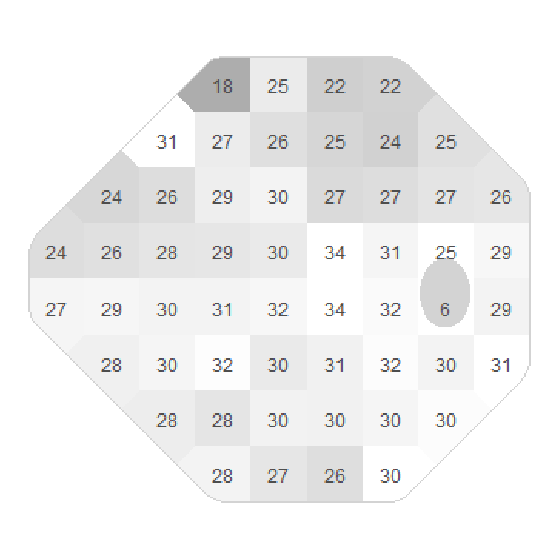

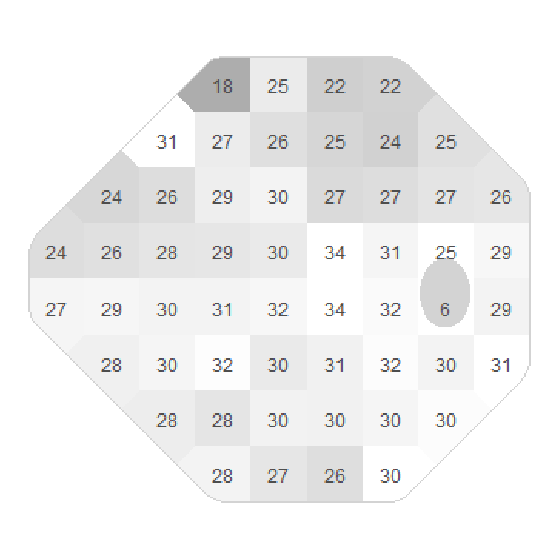

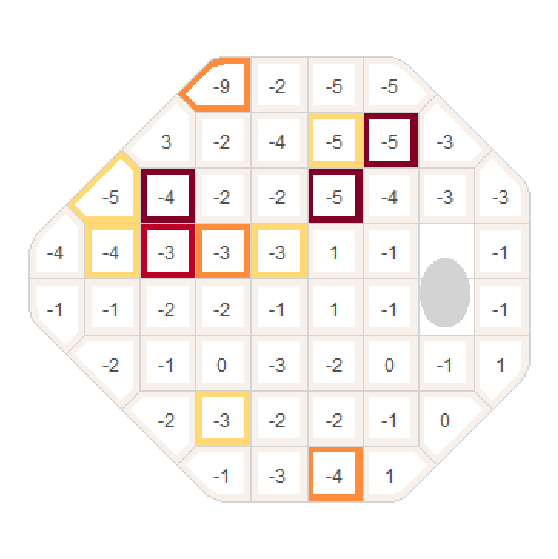

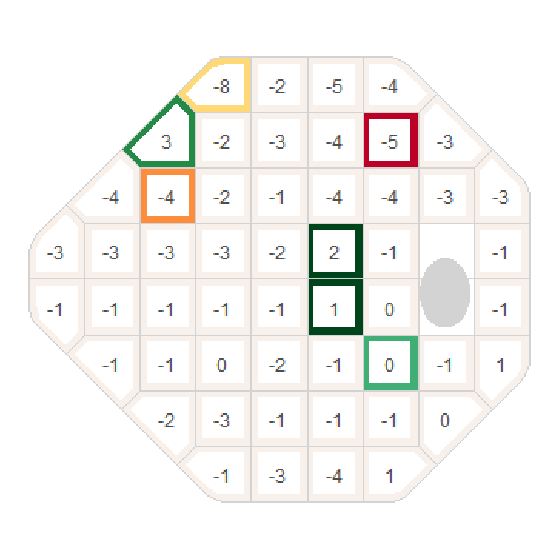

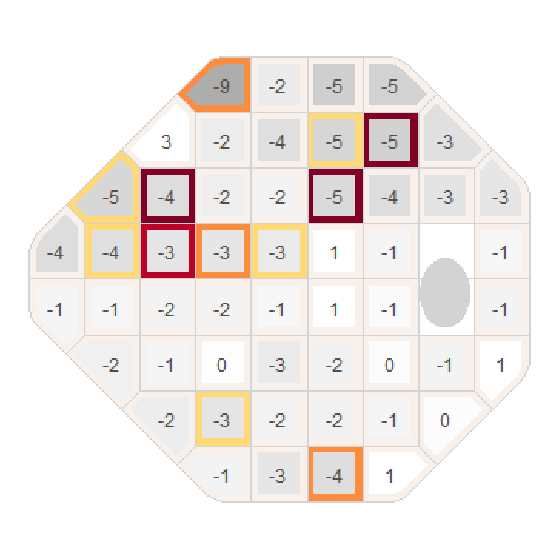

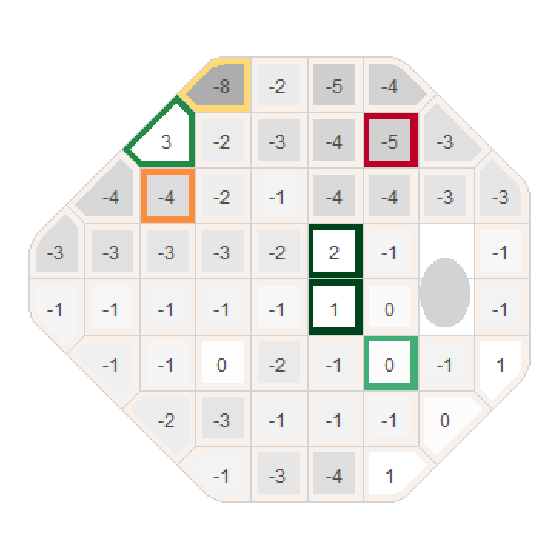

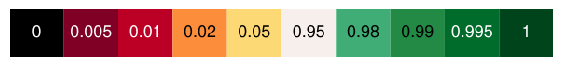

In [70]:
#df_VFs_py = visualFields.data_vfpwgRetest24d2() #df_VFs_py is acquired using vfpwgRetest24d2() function. 
df_VFs_py=df_input
vf = df_VFs_py.iloc[[22]] #Sanity check...lets pick the first VF of df_VFs_py as example

visualFields.vfplot(vf, type='s', save=True, filename='sensitivity', fmt='png') # types: s, td,pd, tds, pds
visualFields.vfplot_s(vf, save=False, filename='s', fmt='png') # alias for vfplot(type='s')
visualFields.vfplot_td(vf, save=True, filename='td', fmt='png') # alias for vfplot(type='td')
visualFields.vfplot_pd(vf, save=True, filename='pd', fmt='pdf') # alias for vfplot(type='pd')
visualFields.vfplot_tds(vf, save=True, filename='tds', fmt='png') # alias for vfplot(type='tds')
visualFields.vfplot_pds(vf, save=True, filename='pds', fmt='png') # alias for vfplot(type='pds')
visualFields.plotProbColormap(save=True, filename='cmap', fmt='pdf') # show colormap of probablies (from visualFields package)

# 0- Data pre-processing: Filling out NaN values in a row with the median of that row


In [11]:
raw_data_pdp = df_pdp.loc[:, 'l1':'l54']
raw_data_td = df_td.loc[:, 'l1':'l54']
raw_data_tdp = df_tdp.loc[:, 'l1':'l54']
# Function to fill NaN values in a row with the median of that row
def fill_nan_with_median(row):
    median_value = row.median()
    return row.fillna(median_value)

# Apply the function to each row
proc_data_pdp = raw_data_pdp.apply(fill_nan_with_median, axis=1)
proc_data_td = raw_data_td.apply(fill_nan_with_median, axis=1)
proc_data_tdp = raw_data_tdp.apply(fill_nan_with_median, axis=1)

df_PDP = proc_data_pdp
df_TD = proc_data_td
df_TDP = proc_data_tdp

# Merge the DataFrames based on the common column 'ID'
df_PDP = df_PDP.set_index(org_data.index)
df_PDP['MD'] = org_data['MTD'].values
# Filter the DataFrame for 'OD' eyes
df_PDP['eye'] = df_input['eye'] 

# 1- HAP2-partI Criteria

In [12]:
def Fn_HAP2_part1(df_PDP):
    
    def HAP2_p1_clc(row):
        count_05 = (row.loc['l1':'l54'] <= 0.05).sum()
        count_01 = (row.loc['l1':'l54'] <= 0.01).sum()
        if count_05 >= 3 and count_01 >= 1:
            return "GL"
        else:
            return "Non-GL"
    
    # Add 'HAP2_part1_clf' column based on the HAP2_part1 function
    df_PDP['HAP2_p1_clf'] = df_PDP.apply(HAP2_p1_clc, axis=1) 
    
    return df_PDP

df_HAP2_p1 = Fn_HAP2_part1(df_PDP)
df_HAP2_p1

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,l48,l49,l50,l51,l52,l53,l54,MD,eye,HAP2_p1_clf
0,0.95,0.95,0.95,0.95,0.950,0.950,0.95,0.95,0.95,0.95,...,0.950,0.95,0.95,0.95,0.95,0.95,0.95,-4.623269,OD,Non-GL
1,0.95,0.95,0.95,0.95,0.950,0.950,0.95,0.95,0.95,0.95,...,0.950,0.95,0.95,0.95,0.95,0.95,0.95,-2.265192,OD,Non-GL
2,0.95,0.05,0.95,0.95,0.950,0.950,0.95,0.95,0.95,0.95,...,0.950,0.95,0.95,0.95,0.95,0.95,0.95,-2.879615,OD,GL
3,0.95,0.05,0.95,0.95,0.950,0.950,0.95,0.95,0.05,0.01,...,0.950,0.95,0.95,0.95,0.05,0.95,0.95,-4.220192,OD,GL
4,0.95,0.95,0.95,0.95,0.950,0.950,0.95,0.95,0.95,0.95,...,0.950,0.05,0.95,0.95,0.95,0.95,0.95,-4.464231,OD,GL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28938,0.95,0.95,0.95,0.95,0.050,0.005,0.95,0.95,0.95,0.95,...,0.950,0.95,0.95,0.95,0.95,0.95,0.95,-4.234231,OS,GL
28939,0.95,0.95,0.98,0.95,0.005,0.950,0.95,0.95,0.95,0.95,...,0.950,0.95,0.95,0.95,0.95,0.95,0.95,-6.987692,OD,GL
28940,0.95,0.95,0.95,0.95,0.950,0.950,0.95,0.05,0.01,0.95,...,0.950,0.95,0.95,0.95,0.95,0.95,0.95,-7.356154,OD,GL
28941,0.95,0.95,0.95,0.95,0.950,0.950,0.98,0.95,0.95,0.95,...,0.005,0.95,0.95,0.95,0.95,0.95,0.95,-3.712500,OS,GL


Non-GL     6057
GL        22886
Name: HAP2_p1_clf, dtype: int64


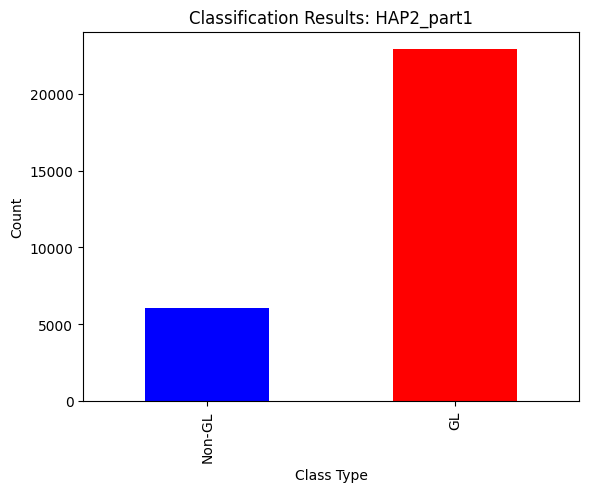

In [13]:
# Visualization df_HAP2_p1
# Count the occurrences of 'GL' and 'Non-GL'
stage_order = ['Non-GL', 'GL']

counts_hap2_p1 = df_HAP2_p1['HAP2_p1_clf'].value_counts().reindex(stage_order)
print(counts_hap2_p1)

# Plot the bar plot
counts_hap2_p1.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: HAP2_part1')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# 2- HAP2-partII Criteria

In [14]:
def Fn_HAP2_part2(row):
  
    # Count the number of values less than 0.05 and 0.01 for each row
    count_05 = (row.loc[:, 'l1':'l54'] <= 0.05).sum(axis=1)
    count_01 = (row.loc[:, 'l1':'l54'] <= 0.01).sum(axis=1)
    
    # Add the count as new columns to the DataFrame
    df_PDP['Count_Less_Than_0.05'] = count_05
    df_PDP['Count_Less_Than_0.01'] = count_01

    # Define a function to apply the conditions and create the new column
    def stage_classification(row):
        if 0.01 <= abs(row['MD']) <= 6 and 1 <= row['Count_Less_Than_0.05'] <= 12 and 1 <= row['Count_Less_Than_0.01'] <= 4:
            return "Stage 1"
        elif 6.01 <= abs(row['MD']) <= 12 and 13 <= row['Count_Less_Than_0.05'] <= 26 and 5 <= row['Count_Less_Than_0.01'] <= 13:
            return "Stage 2"
        elif 12.01 <= abs(row['MD']) and row['Count_Less_Than_0.05'] >= 27 and row['Count_Less_Than_0.01'] >= 14:
            return "Stage 3"
        else:
            return "Non-GL"
    
    df_PDP['HAP2_p2_clf'] = df_PDP.apply(stage_classification, axis=1)
    
    return df_PDP

df_HAP2_p2 = Fn_HAP2_part2(df_PDP.copy())
df_HAP2_p2

,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,...,l51,l52,l53,l54,MD,eye,HAP2_p1_clf,Count_Less_Than_0.05,Count_Less_Than_0.01,HAP2_p2_clf
0,0.95,0.95,0.95,0.95,0.950,0.950,0.95,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,-4.623269,OD,Non-GL,0,0,Non-GL
1,0.95,0.95,0.95,0.95,0.950,0.950,0.95,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,-2.265192,OD,Non-GL,2,0,Non-GL
2,0.95,0.05,0.95,0.95,0.950,0.950,0.95,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,-2.879615,OD,GL,5,1,Stage 1
3,0.95,0.05,0.95,0.95,0.950,0.950,0.95,0.95,0.05,0.01,...,0.95,0.05,0.95,0.95,-4.220192,OD,GL,10,2,Stage 1
4,0.95,0.95,0.95,0.95,0.950,0.950,0.95,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,-4.464231,OD,GL,6,2,Stage 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28938,0.95,0.95,0.95,0.95,0.050,0.005,0.95,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,-4.234231,OS,GL,6,3,Stage 1
28939,0.95,0.95,0.98,0.95,0.005,0.950,0.95,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,-6.987692,OD,GL,17,15,Non-GL
28940,0.95,0.95,0.95,0.95,0.950,0.950,0.95,0.05,0.01,0.95,...,0.95,0.95,0.95,0.95,-7.356154,OD,GL,13,11,Stage 2
28941,0.95,0.95,0.95,0.95,0.950,0.950,0.98,0.95,0.95,0.95,...,0.95,0.95,0.95,0.95,-3.712500,OS,GL,9,6,Non-GL


Classification Results for total eyes:
Non-GL    15171
GL        13772
Name: HAP2_p2_clf, dtype: int64


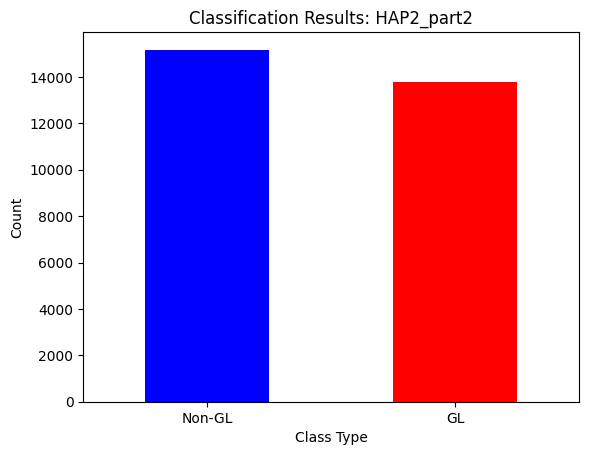

In [15]:
# Assuming 'GL' is included in 'Stage 1', 'Stage 2', and 'Stage 3'
# Filter the DataFrame to include only 'Non-GL' and 'GL'
df_HAP2_p2_2class = df_HAP2_p2[df_HAP2_p2['HAP2_p2_clf'].isin(['Non-GL', 'Stage 1', 'Stage 2', 'Stage 3'])]

# Combine 'Stage 1', 'Stage 2', and 'Stage 3' into one category 'GL'
df_HAP2_p2_2class.loc[df_HAP2_p2_2class['HAP2_p2_clf'].isin(['Stage 1', 'Stage 2', 'Stage 3']), 'HAP2_p2_clf'] = 'GL'

# Count the occurrences of each stage
classification_counts = df_HAP2_p2_2class['HAP2_p2_clf'].value_counts()

# Reorder the DataFrame based on the custom order
counts_hap2_p2 = classification_counts.reindex(['Non-GL', 'GL'])

# Display the classification results
print("Classification Results for total eyes:")
print(counts_hap2_p2)

# Plot the ordered DataFrame
counts_hap2_p2.plot(kind='bar', rot=0, color=['blue', 'red'])
plt.title('Classification Results: HAP2_part2')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

In [71]:
df_HAP2_p2['HAP2_p2_clf'].iloc[[22]]

22    Stage 1
Name: HAP2_p2_clf, dtype: object

Classification Results for total eyes:
Non-GL     15171
Stage 1     8456
Stage 2     1807
Stage 3     3509
Name: HAP2_p2_clf, dtype: int64


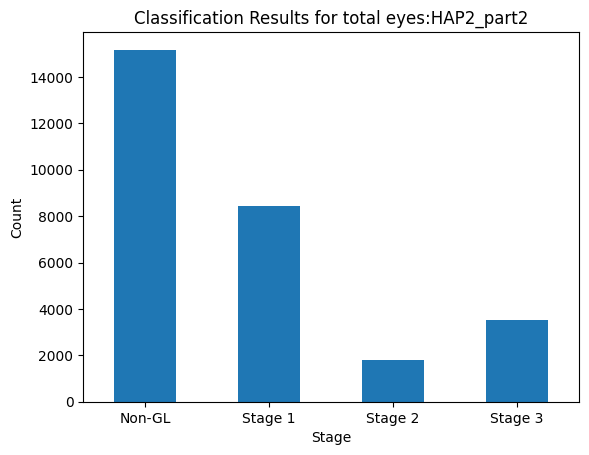

In [16]:
# 4 class classification using HAP2_part2
# Display the count of each unique value in the 'Stage' column
classification_results = df_HAP2_p2['HAP2_p2_clf'].value_counts()
stage_order = ['Non-GL', 'Stage 1', 'Stage 2', 'Stage 3']

# Reorder the DataFrame based on the custom order
classification_results_ordered = classification_results.reindex(stage_order)

# Display the classification results
print("Classification Results for total eyes:")
print(classification_results_ordered)

import matplotlib.pyplot as plt
# Visualizing


# Plot the ordered DataFrame
classification_results_ordered.plot(kind='bar', rot=0)
plt.title('Classification Results for total eyes:HAP2_part2')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.show()

Classification Results for OD Eyes:
Non-GL     7687
Stage 1    4220
Stage 2     838
Stage 3    1688
Name: HAP2_p2_clf, dtype: int64

Classification Results for OS Eyes:
Non-GL     7484
Stage 1    4236
Stage 2     969
Stage 3    1821
Name: HAP2_p2_clf, dtype: int64


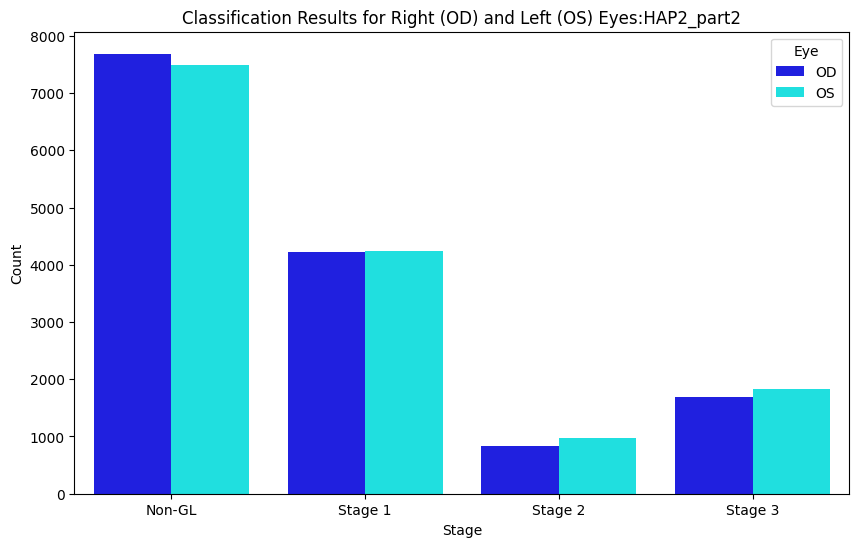

In [17]:
# Filter the DataFrame for 'OD' eyes
df_od = df_HAP2_p2[df_HAP2_p2['eye'] == 'OD']

# Filter the DataFrame for 'OS' eyes
df_os = df_HAP2_p2[df_HAP2_p2['eye'] == 'OS']
stage_order = ['Non-GL', 'Stage 1', 'Stage 2', 'Stage 3']

# Display the count of each unique value in the 'Stage' column for 'OD' eyes
classification_results_od = df_od['HAP2_p2_clf'].value_counts()
classification_results_ordered_od = classification_results_od.reindex(stage_order)

# Display the count of each unique value in the 'Stage' column for 'OS' eyes
classification_results_os = df_os['HAP2_p2_clf'].value_counts()
classification_results_ordered_os = classification_results_os.reindex(stage_order)

# Display the classification results for 'OD' eyes
print("Classification Results for OD Eyes:")
print(classification_results_ordered_od)

# Display the classification results for 'OS' eyes
print("\nClassification Results for OS Eyes:")
print(classification_results_ordered_os)

# Visualizing
# Concatenate 'OD' and 'OS' eyes into one DataFrame
df_both = pd.concat([df_od, df_os])

# Plot a bar plot with 'eye' as hue
plt.figure(figsize=(10, 6))
sns.countplot(x='HAP2_p2_clf', data=df_both, hue='eye', palette={'OD': 'blue', 'OS': 'cyan'}, order=stage_order)
plt.title('Classification Results for Right (OD) and Left (OS) Eyes:HAP2_part2')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.legend(title='Eye', loc='upper right')

# Show the plot
plt.show()

In [18]:
# save tdp and pdp into the csv file
# We need to merge these new data into the original VFs

directory_path = '/PyVisualField/Output/'
name1 = 'TDP_data'
name2 = 'PDP_data'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_file_name1 = f'{name1}_{timestamp}.csv'
csv_file_name2 = f'{name2}_{timestamp}.csv'

csv_file_path1 = f'{directory_path}{csv_file_name1}'
csv_file_path2 = f'{directory_path}{csv_file_name2}'


df_tdp.to_csv(csv_file_path1, index=False)
df_pdp.to_csv(csv_file_path2, index=False)

# 3- UKGTS

In [19]:
def check_gl_condition(row, threshold=0.01, consecutive_reductions=2):
    # Convert values to numeric, handling errors by setting them to NaN
    numeric_values = pd.to_numeric(row.values, errors='coerce')
    below_threshold = numeric_values < threshold
    consecutive_counts = np.convolve(below_threshold, np.ones(consecutive_reductions), mode='valid')

    return np.any(consecutive_counts >= consecutive_reductions)

def Fn_UKGTS(df_TDP, threshold=0.01, consecutive_reductions=2):
    # Apply the condition to identify GL or Non-GL
    df_TDP['UKGTS_clf'] = np.where(df_TDP.apply(check_gl_condition, axis=1, threshold=threshold, consecutive_reductions=consecutive_reductions), 'GL', 'Non-GL')

    return df_TDP

# Assuming df_UKGTS is your DataFrame
df_UKGTS = Fn_UKGTS(df_TDP)

# Display the result
print(df_UKGTS)

         l1    l2    l3    l4    l5     l6    l7    l8     l9    l10  ...  \
1      0.95  0.95  0.95  0.95  0.95  0.950  0.02  0.95  0.950  0.950  ...   
2      0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.95  0.950  0.950  ...   
3      0.95  0.05  0.95  0.95  0.95  0.950  0.95  0.95  0.950  0.950  ...   
4      0.95  0.05  0.95  0.95  0.95  0.950  0.95  0.95  0.050  0.005  ...   
5      0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.95  0.050  0.950  ...   
...     ...   ...   ...   ...   ...    ...   ...   ...    ...    ...  ...   
28939  0.95  0.95  0.95  0.95  0.02  0.005  0.95  0.95  0.950  0.950  ...   
28940  0.95  0.95  0.95  0.95  0.05  0.950  0.95  0.95  0.950  0.950  ...   
28941  0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.05  0.005  0.950  ...   
28942  0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.95  0.050  0.950  ...   
28943  0.95  0.95  0.95  0.95  0.95  0.950  0.95  0.95  0.950  0.950  ...   

         l46    l47    l48    l49   l50   l51   l52   l53   l54  UKGTS_clf 

Non-GL     9042
GL        19901
Name: UKGTS_clf, dtype: int64


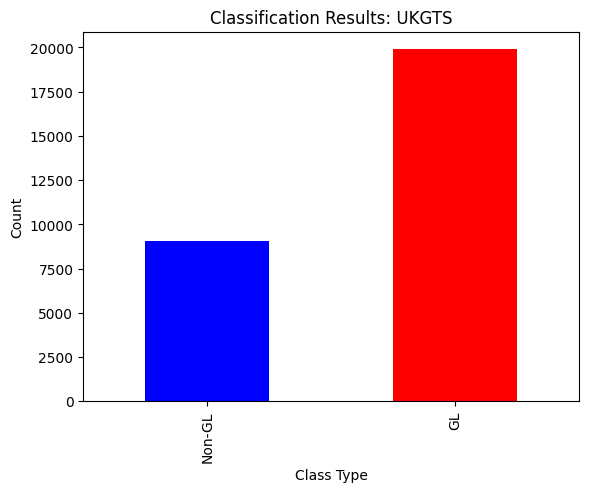

In [20]:
# Visualization UKGTS
# Count the occurrences of 'GL' and 'Non-GL'
stage_order = ['Non-GL', 'GL']

counts_ukgts = df_UKGTS['UKGTS_clf'].value_counts().reindex(stage_order)
print(counts_ukgts)

# Plot the bar plot
counts_ukgts.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: UKGTS')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# 4- LoGTS

In [21]:
def LoGTS_clf(row):
    # Convert values to numeric, handling errors by setting them to NaN
    numeric_values = pd.to_numeric(row, errors='coerce')
    
    # Count values less than -10
    count_less_than_10 = (numeric_values < -10).sum()
    
    if count_less_than_10 >= 2:
        return "GL"
    else:
        return "Non-GL"

def Fn_LoGTS(df_LoGTS):
    # Add 'LoGTS_clf' column based on the LoGTS_clf function
    df_TD['LoGTS_clf'] = df_TD.apply(LoGTS_clf, axis=1)
    
    return df_TD

# Assuming df_LoGTS is your DataFrame
df_LoGTS = Fn_LoGTS(df_TD)

# Display the result
print(df_LoGTS)

             l1        l2        l3        l4        l5        l6        l7  \
1     -0.644665 -4.170592 -5.221520 -2.797450 -2.214469 -2.215394 -4.741320   
2      0.418493 -1.110465  0.839327 -0.732129 -0.151032  0.841258 -2.687700   
3     -4.518349 -6.050339 -4.099826 -3.666807  1.912405  0.897910 -1.634080   
4     -3.328875 -6.869961 -5.917284 -6.470844  1.102716 -1.932134 -2.473221   
5     -2.265716 -4.809835 -0.856437 -4.405522 -2.833847 -1.875482 -3.419601   
...         ...       ...       ...       ...       ...       ...       ...   
28939 -4.823610 -1.388952 -0.430507 -0.948274 -5.389789 -6.478919 -4.044261   
28940  2.060603  2.452813  2.421353 -5.033777 -4.501672  0.314208  1.706417   
28941 -0.876239 -0.487061 -4.517800 -5.968456 -1.438235 -1.629141 -2.239963   
28942  1.302706  1.731300 -0.308813 -0.817631  0.737085  0.634385  1.062978   
28943 -2.697294 -0.268700  1.691187  1.182369 -1.262915 -1.365615  1.062978   

             l8        l9       l10  ...       l46 

Non-GL    15596
GL        13347
Name: LoGTS_clf, dtype: int64


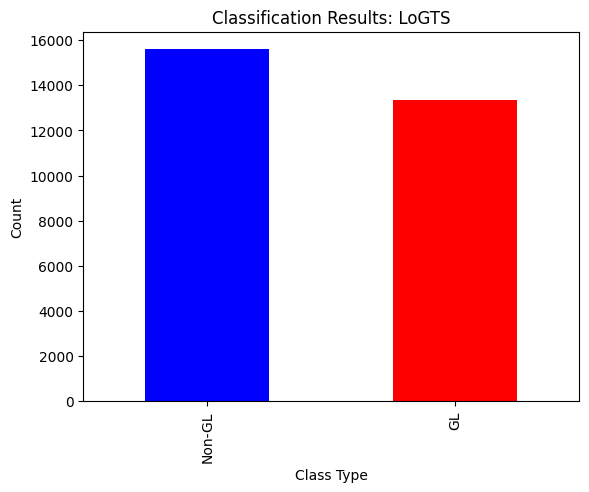

In [22]:
# Visualization LoGTS
# Count the occurrences of "GL" and "Non-GL"
stage_order = ['Non-GL', 'GL']

counts_logts = df_LoGTS['LoGTS_clf'].value_counts().reindex(stage_order)
print(counts_logts)
counts_logts.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: LoGTS')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# 5- Kang's Method: https://iovs.arvojournals.org/article.aspx?articleid=2279162

In [23]:
def Kangs_clf(row):
    # Convert values to numeric, handling errors by setting them to NaN
    numeric_values = pd.to_numeric(row, errors='coerce')
    
    # Count values less than -5
    count_less_than_5 = (numeric_values < -5).sum()
    
    if count_less_than_5 >= 3:
        return "GL"
    else:
        return "Non-GL"

def Fn_Kangs(row):
    df_TD['Kangs_clf'] = df_TD.apply(Kangs_clf, axis=1)
    
    return df_TD

df_Kangs = Fn_Kangs(df_TD)

# Display the result
print(df_Kangs)

             l1        l2        l3        l4        l5        l6        l7  \
1     -0.644665 -4.170592 -5.221520 -2.797450 -2.214469 -2.215394 -4.741320   
2      0.418493 -1.110465  0.839327 -0.732129 -0.151032  0.841258 -2.687700   
3     -4.518349 -6.050339 -4.099826 -3.666807  1.912405  0.897910 -1.634080   
4     -3.328875 -6.869961 -5.917284 -6.470844  1.102716 -1.932134 -2.473221   
5     -2.265716 -4.809835 -0.856437 -4.405522 -2.833847 -1.875482 -3.419601   
...         ...       ...       ...       ...       ...       ...       ...   
28939 -4.823610 -1.388952 -0.430507 -0.948274 -5.389789 -6.478919 -4.044261   
28940  2.060603  2.452813  2.421353 -5.033777 -4.501672  0.314208  1.706417   
28941 -0.876239 -0.487061 -4.517800 -5.968456 -1.438235 -1.629141 -2.239963   
28942  1.302706  1.731300 -0.308813 -0.817631  0.737085  0.634385  1.062978   
28943 -2.697294 -0.268700  1.691187  1.182369 -1.262915 -1.365615  1.062978   

             l8        l9       l10  ...       l47 

Non-GL     9030
GL        19913
Name: Kangs_clf, dtype: int64


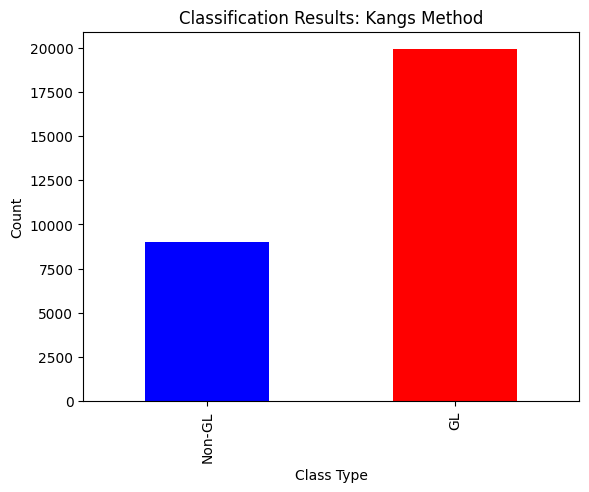

In [24]:
# Visualization LoGTS
# Count the occurrences of "GL" and "Non-GL"
stage_order = ['Non-GL', 'GL']

counts_kangs = df_Kangs['Kangs_clf'].value_counts().reindex(stage_order)
print(counts_kangs)
counts_kangs.plot(kind='bar', color=['blue', 'red'])
plt.title('Classification Results: Kangs Method')
plt.xlabel('Class Type')
plt.ylabel('Count')
plt.show()

# Comparing results........ Checking agreement or disagreement.... Intraclass Correlation Coefficient (ICC) was used

In [25]:
tot_counts = pd.DataFrame({
    'HAP2_p1_clf': counts_hap2_p1,
    'HAP2_p2_clf': counts_hap2_p2,
    'UKGTS_clf': counts_ukgts,
    'LoGTS_clf': counts_logts,
    'Kangs_clf': counts_kangs
})
print("Classification Results:")
print(tot_counts)

Classification Results:
        HAP2_p1_clf  HAP2_p2_clf  UKGTS_clf  LoGTS_clf  Kangs_clf
Non-GL         6057        15171       9042      15596       9030
GL            22886        13772      19901      13347      19913


Classification results
        HAP2_p1_clf  HAP2_p2_clf  UKGTS_clf  LoGTS_clf  Kangs_clf
Non-GL         6057        15171       9042      15596       9030
GL            22886        13772      19901      13347      19913


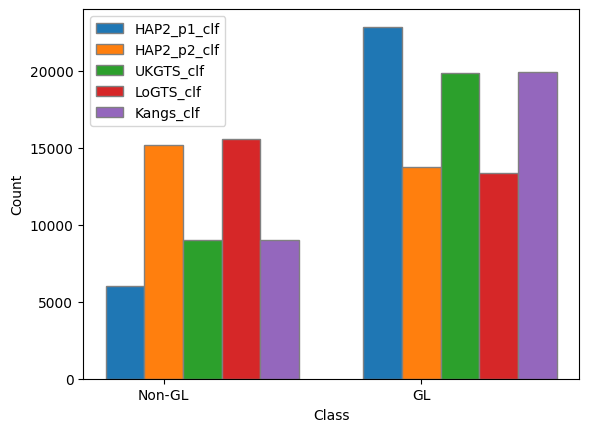

In [26]:
# Plot 3 methods in one graph
categories = ['Non-GL', 'GL']
print('Classification results')
print(tot_counts)
# Bar width
bar_width = 0.15

# Set up positions for bars on x-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]


# Create bar plots
plt.bar(r1, counts_hap2_p1, width=bar_width, edgecolor='grey', label='HAP2_p1_clf')
plt.bar(r2, counts_hap2_p2, width=bar_width, edgecolor='grey', label='HAP2_p2_clf')
plt.bar(r3, counts_ukgts, width=bar_width, edgecolor='grey', label='UKGTS_clf')
plt.bar(r4, counts_logts, width=bar_width, edgecolor='grey', label='LoGTS_clf')
plt.bar(r5, counts_kangs, width=bar_width, edgecolor='grey', label='Kangs_clf')

# Labeling
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([r + bar_width for r in range(len(categories))], categories)

# Add legend
plt.legend()

plt.savefig('imshow_plot.png')
# Show the plot
plt.show()

In [27]:
# Check agreement/disagreement
# Intraclass Correlation Coefficient (ICC) 
non_gl_all=[counts_hap2_p1['Non-GL'], counts_hap2_p2['Non-GL'], counts_ukgts['Non-GL'], counts_logts['Non-GL'], counts_kangs['Non-GL']]
gl_all=[counts_hap2_p1['GL'], counts_hap2_p2['GL'], counts_ukgts['GL'], counts_logts['GL'], counts_kangs['GL']]
#1- UKGTS & LoGTS
non_gl_ukgts_logts=[counts_ukgts['Non-GL'], counts_logts['Non-GL']]
gl_ukgts_logts=[counts_ukgts['GL'], counts_logts['GL']]
#2- HAP2_part1 & UKGTS
non_gl_hap2p1_ukgts=[counts_hap2_p1['Non-GL'], counts_ukgts['Non-GL']]
gl_hap2p1_ukgts=[counts_hap2_p1['GL'], counts_ukgts['GL']]
#3- HAP2_part1 & LoGTS
non_gl_hap2p1_logts=[counts_hap2_p1['Non-GL'], counts_logts['Non-GL']]
gl_hap2p1_logts=[counts_hap2_p1['GL'], counts_logts['GL']]
#4- HAP2_part2 & UKGTS
non_gl_hap2p2_ukgts=[counts_hap2_p2['Non-GL'], counts_ukgts['Non-GL']]
gl_hap2p2_ukgts=[counts_hap2_p2['GL'], counts_ukgts['GL']]
#5- HAP2_part2 & LoGTS
non_gl_hap2p2_logts=[counts_hap2_p2['Non-GL'], counts_logts['Non-GL']]
gl_hap2p2_logts=[counts_hap2_p2['GL'], counts_logts['GL']]
#6- HAP2_part1 & Kangs
non_gl_hap2p1_kangs=[counts_hap2_p1['Non-GL'], counts_kangs['Non-GL']]
gl_hap2p1_kangs=[counts_hap2_p1['GL'], counts_kangs['GL']]
#1- Kangs & UKGTS
non_gl_kangs_ukgts=[counts_kangs['Non-GL'], counts_ukgts['Non-GL']]
gl_kangs_ukgts=[counts_kangs['GL'], counts_ukgts['GL']]


# Combine the data into a list of arrays
data_all = [non_gl_all, gl_all]
data_ukgts_logts = [non_gl_ukgts_logts, gl_ukgts_logts]
data_hap2p1_ukgts = [non_gl_hap2p1_ukgts, gl_hap2p1_ukgts]
data_hap2p1_logts = [non_gl_hap2p1_logts, gl_hap2p1_logts]
data_hap2p2_ukgts = [non_gl_hap2p2_ukgts, gl_hap2p2_ukgts]
data_hap2p2_logts = [non_gl_hap2p2_logts, gl_hap2p2_logts]
data_hap2p1_kangs = [non_gl_hap2p1_kangs, gl_hap2p1_kangs]
data_kangs_ukgts = [non_gl_kangs_ukgts, gl_kangs_ukgts]

# Perform one-way ANOVA to obtain the total variance
total_variance_all = np.var(np.concatenate(data_all))
total_variance_ukgts_logts = np.var(np.concatenate(data_ukgts_logts))
total_variance_hap2p1_ukgts = np.var(np.concatenate(data_hap2p1_ukgts))
total_variance_hap2p1_logts = np.var(np.concatenate(data_hap2p1_logts))
total_variance_hap2p2_ukgts = np.var(np.concatenate(data_hap2p2_ukgts))
total_variance_hap2p2_logts = np.var(np.concatenate(data_hap2p2_logts))
total_variance_hap2p1_kangs = np.var(np.concatenate(data_hap2p1_kangs))
total_variance_kangs_ukgts = np.var(np.concatenate(data_kangs_ukgts))

# Calculate the residual variance (within-group variance)
residual_variance_all = np.mean([np.var(arr) for arr in data_all])
residual_variance_ukgts_logts = np.mean([np.var(arr) for arr in data_ukgts_logts])
residual_variance_hap2p1_ukgts = np.mean([np.var(arr) for arr in data_hap2p1_ukgts])
residual_variance_hap2p1_logts = np.mean([np.var(arr) for arr in data_hap2p1_logts])
residual_variance_hap2p2_ukgts = np.mean([np.var(arr) for arr in data_hap2p2_ukgts])
residual_variance_hap2p2_logts = np.mean([np.var(arr) for arr in data_hap2p2_logts])
residual_variance_hap2p1_kangs = np.mean([np.var(arr) for arr in data_hap2p1_kangs])
residual_variance_kangs_ukgts = np.mean([np.var(arr) for arr in data_kangs_ukgts])

# Calculate the ICC
icc_all = (total_variance_all - residual_variance_all) / total_variance_all
icc_ukgts_logts = (total_variance_ukgts_logts - residual_variance_ukgts_logts) / total_variance_ukgts_logts
icc_hap2p1_ukgts = (total_variance_hap2p1_ukgts - residual_variance_hap2p1_ukgts) / total_variance_hap2p1_ukgts
icc_hap2p1_logts = (total_variance_hap2p1_logts - residual_variance_hap2p1_logts) / total_variance_hap2p1_logts
icc_hap2p2_ukgts = (total_variance_hap2p2_ukgts - residual_variance_hap2p2_ukgts) / total_variance_hap2p2_ukgts
icc_hap2p2_logts = (total_variance_hap2p2_logts - residual_variance_hap2p2_logts) / total_variance_hap2p2_logts
icc_hap2p1_kangs = (total_variance_hap2p1_kangs - residual_variance_hap2p1_kangs) / total_variance_hap2p1_kangs
icc_kangs_ukgts = (total_variance_kangs_ukgts - residual_variance_kangs_ukgts) / total_variance_kangs_ukgts

icc_values = {
    "UKGTS and LoGTS": icc_ukgts_logts,
    "HAP2_part1 and UKGTS": icc_hap2p1_ukgts,
    "HAP2_part1 and LoGTS": icc_hap2p1_logts,
    "HAP2_part2 and UKGTS": icc_hap2p2_ukgts,
    "HAP2_part2 and LoGTS": icc_hap2p2_logts,
    "HAP2_part1 and Kangs": icc_hap2p1_kangs,
    "Kangs and UKGTS": icc_kangs_ukgts
}

best_pair = max(icc_values, key=icc_values.get)
best_icc = icc_values[best_pair]

# Print the result
print("\033[1mTotal Intraclass Correlation Coefficient (ICC):\033[0m")
print(f"Four Criteria ICC= {icc_all}")
print("\033[1mPair Intraclass Correlation Coefficient (ICC):\033[0m")
print(f"UKGTS and LoGTS ICC= {icc_ukgts_logts}")
print(f"HAP2_part1 and UKGTS ICC= {icc_hap2p1_ukgts}")
print(f"HAP2_part1 and LoGTS ICC= {icc_hap2p1_logts}")
print(f"HAP2_part2 and UKGTS ICC= {icc_hap2p2_ukgts}")
print(f"HAP2_part2 and LoGTS ICC= {icc_hap2p2_logts}")
print(f"HAP2_part1 and Kangs ICC= {icc_hap2p1_kangs}")
print(f"Kangs and UKGTS ICC= {icc_kangs_ukgts}")

print(f"\033[1mThe pair with the highest ICC is {best_pair} with an ICC of {best_icc}.\033[0m")

Total Intraclass Correlation Coefficient (ICC):
Four Criteria ICC= 0.46321446705624114
Pair Intraclass Correlation Coefficient (ICC):
UKGTS and LoGTS ICC= 0.3014091006885399
HAP2_part1 and UKGTS ICC= 0.9555747231463972
HAP2_part1 and LoGTS ICC= 0.3687064372072383
HAP2_part2 and UKGTS ICC= 0.37327023475988114
HAP2_part2 and LoGTS ICC= 0.9485046902427043
HAP2_part1 and Kangs ICC= 0.9559884451063504
Kangs and UKGTS ICC= 0.9999987815071885
The pair with the highest ICC is Kangs and UKGTS with an ICC of 0.9999987815071885.


# All criteria in one function and make Ensemble majority voting classifier

In [47]:
def combine_dataframes(org_str, df1, df2, df3, df4, df5):
    # Combine the DataFrames along the columns axis
    result_combined = pd.concat([df1, df2], axis=1)
    
    # Reset indices to ensure proper alignment
    m1_reset = org_str.reset_index(drop=True)
    m2_reset = result_combined.reset_index(drop=True)
    
    # Add the specified columns from m1_reset to the first three columns of m2_reset
    m2_reset.insert(0, 'ID', m1_reset['id'])
    m2_reset.insert(1, 'Eye', m1_reset['eye'])
    m2_reset.insert(2, 'Age', m1_reset['age'])
    
    result_combined = m2_reset
    
    # Concatenate df3
    result_combined = pd.concat([result_combined, df3.reset_index(drop=True)], axis=1)
    
    # Concatenate df4
    result_combined = pd.concat([result_combined, df4.reset_index(drop=True)], axis=1)
    
    # Concatenate df5
    result_combined = pd.concat([result_combined, df5.reset_index(drop=True)], axis=1)

    # Return the combined DataFrame
    return result_combined

# Call the function with your DataFrames
result_combined = combine_dataframes(df_input, df_UKGTS['UKGTS_clf'], df_LoGTS['LoGTS_clf'], df_Kangs['Kangs_clf'], df_HAP2_p1['HAP2_p1_clf'], df_HAP2_p2_2class['HAP2_p2_clf'])

# Convert data type to string to ensure consistency
result_combined_en = result_combined.astype(str)

def Fn_ensemble_decision(result_combined_en):
    # Perform majority voting ensemble
    result_combined['Ensemble'] = result_combined_en.mode(axis=1)[0]
    return result_combined

result_combined = Fn_ensemble_decision(result_combined_en)

# Calculate the probability of Ensemble majority vote being 'GL' or 'Non-GL' for each row
num_classifiers = 5  # Number of classifiers used
result_combined['GL_Probability'] = result_combined_en.apply(lambda row: row.value_counts().get('GL', 0) / num_classifiers, axis=1)
result_combined['Non_GL_Probability'] = result_combined_en.apply(lambda row: row.value_counts().get('Non-GL', 0) / num_classifiers, axis=1)

# Show the combined DataFrame
print(result_combined)

         ID Eye  Age UKGTS_clf LoGTS_clf Kangs_clf HAP2_p1_clf HAP2_p2_clf  \
0       647  OD   52        GL    Non-GL        GL      Non-GL      Non-GL   
1       647  OD   53    Non-GL    Non-GL    Non-GL      Non-GL      Non-GL   
2       647  OD   54    Non-GL    Non-GL        GL          GL          GL   
3       647  OD   57        GL    Non-GL        GL          GL          GL   
4       647  OD   58        GL    Non-GL        GL          GL          GL   
...     ...  ..  ...       ...       ...       ...         ...         ...   
28938  7324  OS   65    Non-GL    Non-GL        GL          GL          GL   
28939  6859  OD   79        GL        GL        GL          GL      Non-GL   
28940  6859  OD   80        GL        GL        GL          GL          GL   
28941  1142  OS   67        GL    Non-GL        GL          GL      Non-GL   
28942  1142  OS   67        GL    Non-GL        GL          GL      Non-GL   

      Ensemble  GL_Probability  Non_GL_Probability  
0       No

# Show the final results of each function

In [45]:
# 2- HAP2_p1 function
print("\nResult of Fn_HAP2_p1:")
print(Fn_HAP2_part2(df_HAP2_p1))
# 2- HAP2_p2 function
print("\nResult of Fn_HAP2_p2:")
print(Fn_HAP2_part2(df_HAP2_p2))
# 3- UKGTS fucntion
print("Result of Fn_UKGTS:")
print(Fn_UKGTS(df_UKGTS))
# 4- LoGTS function
print("\nResult of Fn_LoGTS:")
print(Fn_LoGTS(df_LoGTS))
# 5- 
print("\nResult of Fn_Kangs:")
print(Fn_Kangs(df_Kangs))
# 6- Ensemble 
print("\nResult of Ensemble:")
print(Fn_ensemble_decision(result_combined_en))


Result of Fn_HAP2_p1:
         l1    l2    l3    l4     l5     l6    l7    l8    l9   l10  ...  \
0      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
1      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
2      0.95  0.05  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
3      0.95  0.05  0.95  0.95  0.950  0.950  0.95  0.95  0.05  0.01  ...   
4      0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   
...     ...   ...   ...   ...    ...    ...   ...   ...   ...   ...  ...   
28938  0.95  0.95  0.95  0.95  0.050  0.005  0.95  0.95  0.95  0.95  ...   
28939  0.95  0.95  0.98  0.95  0.005  0.950  0.95  0.95  0.95  0.95  ...   
28940  0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.05  0.01  0.95  ...   
28941  0.95  0.95  0.95  0.95  0.950  0.950  0.98  0.95  0.95  0.95  ...   
28942  0.95  0.95  0.95  0.95  0.950  0.950  0.95  0.95  0.95  0.95  ...   

        l51   l52   l53   l54        MD  eye  HAP2_p1_clf  \
0  

In [48]:
#Save classification results
# save tdp and pdp into the csv file
# We need to merge these new data into the original VFs

directory_path = '/PyVisualField/Output/'
name1 = 'HAP2_part1_clf'
name2 = 'HAP2_part2_clf'
name3 = 'UKGTS_clf'
name4 = 'LoGTS_clf'
name5 = 'Kangs_clf'
name6 = 'Ensemble'

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_file_name1 = f'{name1}_{timestamp}.csv'
csv_file_name2 = f'{name2}_{timestamp}.csv'
csv_file_name3 = f'{name3}_{timestamp}.csv'
csv_file_name4 = f'{name4}_{timestamp}.csv'
csv_file_name5 = f'{name5}_{timestamp}.csv'
csv_file_name6 = f'{name6}_{timestamp}.csv'

csv_file_path1 = f'{directory_path}{csv_file_name1}'
csv_file_path2 = f'{directory_path}{csv_file_name2}'
csv_file_path3 = f'{directory_path}{csv_file_name3}'
csv_file_path4 = f'{directory_path}{csv_file_name4}'
csv_file_path5 = f'{directory_path}{csv_file_name5}'
csv_file_path6 = f'{directory_path}{csv_file_name6}'

Fn_HAP2_part1(df_PDP).to_csv(csv_file_path1, index=False)
Fn_HAP2_part2(df_PDP).to_csv(csv_file_path2, index=False)
Fn_UKGTS(df_TDP).to_csv(csv_file_path3, index=False)
Fn_LoGTS(df_TD).to_csv(csv_file_path4, index=False)
Fn_Kangs(df_TD).to_csv(csv_file_path5, index=False)
Fn_ensemble_decision(result_combined_en).to_csv(csv_file_path6, index=False)
